# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

# Import

In [1]:
import os
print(os.environ.get('TF_ENABLE_ONEDNN_OPTS'), os.environ.get('TF_CPP_MIN_LOG_LEVEL'))

import random
from collections import defaultdict
import numpy as np
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, AdditiveAttention, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import string
import matplotlib.pyplot as plt

0 3


E0000 00:00:1749733436.948028 2793706 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749733436.951751 2793706 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_depth=MAX_DEPTH):
    max_len = 4*2**max_depth -2
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(max_depth)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix, max_depth = max_depth))
        Y.append(encode(postfix, max_depth= max_depth))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

In [4]:
# Let us define a simple dataset, and inspect a few samples.
X_train, Y_train = generate_dataset(10)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(10)
decoder_input_val = shift_right(Y_val)
i =  np.random.randint(10)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

4
infix :  ( ( e / c ) / a )
posfix notation:  e c / a /
teacher forcing :  SOS e c / a /


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.




# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [5]:
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# What to deliver

As usual you are supposed to deliver a single notebook witten in Keras. You are auhtorized to use Keras3 with pytorch as backend if your prefer.

Do no upload a zip file: the submission will be rejected.

The python notebook should have a clear documentation of the training phase, possibly with its history.

You should be able to provide the network paramters upon request. Even better, consider a way to upload them inside your notebook using gdown.

---

# DL Project start 

Leonardo Billi 0001189587

06/25

## History function

In [6]:
import json
from IPython import get_ipython

def generate_report(hparams: dict, outputs: dict, figures: dict, model = None, output_path="progettoDL/report", title = "try"): #, metrics: dict
    """
    Automatically generates a Markdown report including:

    Hyperparameters (hparams)
    Training/validation metrics (outputs: dict of lists per epoch)
    Figures (dict name->matplotlib.Figure)
    """
    # Salva le figure su file
    for name, fig in figures.items():
        filename = f"{output_path}/img/{name}_{title}.png"
        fig.savefig(filename, bbox_inches='tight')

    if model is not None:
        model.save(f"{output_path}/model/{title}/seq2seq_attention_{title}.h5")
        model.save_weights(f"{output_path}/model/{title}/seq2seq_attention_{title}.weights.h5")
    
    # Scrive il report.md
    with open(f"{output_path}/report.md", 'a') as f:
        f.write("\n\n---\n\n")
        f.write(f"# {title}\n\n")
        
        # Iperparametri
        f.write("## Hyperparameters\n")
        for key, value in hparams.items():
            f.write(f"- **{key}**: {value}\n")
        f.write("\n")
        
        f.write("## Output di cells\n")
        for name, out in outputs.items():
            f.write(f"### {name}\n")
            f.write("```\n")
            if isinstance(out, (list, tuple)):
                f.write("".join(map(str, out)))
            else:
                f.write(out)
                if not out.endswith("\n"):
                    f.write("\n")
            f.write("```\n\n")
        
        # Figures
        f.write("## Figures\n")
        for name in figures.keys():
            f.write(f"### {name}\n")
            f.write(f"![{name}](img/{name}_{title}.png)\n\n")


## MODEL

### Choice

During the task analysis, after some research I considered implementing either an RNN or a Transformer.
After reviewing the following resources (and others linked within them), I decided to use an **encoder–decoder RNN with attention**:

\[1]: [https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras](https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras) “How to Develop a Seq2Seq Model for Neural Machine Translation in Keras”  
\[2]: [https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras) “How to Develop an Encoder-Decoder Model with Attention in Keras”

I concluded that this architecture is better suited given the nature of the two models:

* **RNN + Attention**
  The LSTM processes tokens **one at a time**, maintaining a recurrent state $h_t$ that encodes the entire history of previous tokens. The attention mechanism then “picks out” only the relevant elements (parentheses, operators, identifiers) whenever a new token needs to be generated. This model is **inherently sequential** and finely tuned for data where order and grouping are fundamental (e.g., parentheses).

* **Transformer**
  Primarily based on **self-attention** over the tokens of the same sequence, combined with Positional Encoding to inject order information. This is ideal for very long sequences or those with long-range dependencies (e.g., paragraphs of text), but for moderate lengths (\~30 tokens) with tree-like structures already made explicit by parentheses, the overhead of managing Positional Encoding and multi-head self-attention didn’t seem to offer a real advantage.  


---


### Model Overview

1. **Encoder**

   * A single unidirectional LSTM (`enc_units`, `return_sequences=True`) reads the variable-length token sequence, first mapped through an **Embedding** of dimension `embed_dim`.
   * Outputs:

     * `enc_outputs`: all hidden states (shape `[batch, variable_length, enc_units]`)
     * Final state: `state_h`, `state_c` (to initialize the decoder)

2. **Decoder + Attention**

   * **Decoder**: another unidirectional LSTM of equal capacity (`dec_units`), fed with the “shifted” token sequence for *teacher forcing*:

     ```python
     dec_inputs = [SOS] + y_true[:-1]
     ```

     Its initial hidden state is set to `state_h, state_c` from the encoder.
   * **Attention**: an **Additive (Bahdanau) Attention** mechanism over `[dec_outputs, enc_outputs]` computes, at each decoder step, a context vector highlighting the most relevant infix tokens for the current output. This vector is concatenated with `dec_outputs` and projected via `Dense(vocab_size, activation='softmax')` to yield the next-token probability distribution:

   $$
   e_{t,i} = v^\top \tanh\bigl(W_q\,h_t + W_k\,H_i\bigr)
   $$

Additional Key Concepts:

1. **$h$ and $c$**

   * In an LSTM, **$h_t$** is the *hidden state* and **$c_t$** is the *cell state*.
   * The hidden state $h_t \in \mathbb{R}^{\text{units}}$ encodes all the useful information up to time step $t$.
   * The cell state $c_t \in \mathbb{R}^{\text{units}}$ carries long-term memory (via its “gates”), helping to mitigate the vanishing gradient problem.

2. **Additive (Bahdanau) Attention**

   * At each decoder step $t$, for every encoder time step $i = 1 \ldots L$, we compute the alignment score:

     $$
       e_{t,i} = v^\top \tanh\bigl(W_q\,h_t^{\text{dec}} + W_k\,h_i^{\text{enc}}\bigr)
       \quad \in \mathbb{R}.
     $$
   * **Attention weights**:

     $$
       \alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_j \exp(e_{t,j})}.
     $$
   * **Context vector**:

     $$
       c_t = \sum_{i=1}^L \alpha_{t,i}\,h_i^{\text{enc}}.
     $$
   * **Concatenation & output**:

     $$
       \bigl[h_t^{\text{dec}};\;c_t\bigr]
       \;\xrightarrow{\text{Dense}(\text{vocab\_size}, \,\text{softmax})}\;\text{next-token distribution}.
     $$
   * This mechanism allows the decoder to dynamically “unlock” the most relevant parts of the encoder’s outputs when deciding which token to emit.


In [ ]:
def create_encoder_model(vocab_size, embed_dim, enc_units):
    # Input of arbitrary length for infix sequence
    enc_inputs = Input(shape=(None,), name="enc_inputs")  # (batch, variable_length)
    # Embedding
    x = Embedding(input_dim=vocab_size,
                  output_dim=embed_dim,
                  name="enc_embedding")(enc_inputs)
    # LSTM returns all hidden states and the final (h, c) states; 
    enc_outputs, state_h, state_c = LSTM(enc_units,
                                        return_sequences=True,
                                        return_state=True,
                                        name="encoder_lstm")(x)
    # Model outputs encoder hidden sequence and final states
    return Model(enc_inputs, [enc_outputs, state_h, state_c], name="encoder_model")

def create_decoder_model(vocab_size, embed_dim, dec_units):
    # Decoder inputs (token IDs) of variable length for teacher forcing
    dec_inputs = Input(shape=(None,), name="dec_inputs")  # (batch, variable_length)
    # Encoder outputs and states come from encoder
    enc_outputs = Input(shape=(None, dec_units), name="enc_outputs")  # (batch, enc_len, units)
    state_h_in  = Input(shape=(dec_units,), name="h_in")
    state_c_in  = Input(shape=(dec_units,), name="c_in")

    # Embedding of decoder input
    x = Embedding(input_dim=vocab_size,
                  output_dim=embed_dim,
                  name="dec_embedding")(dec_inputs)
    # Decoder LSTM consumes masked embeddings and initial states
    dec_outputs, state_h_out, state_c_out = LSTM(dec_units,
                                                return_sequences=True,
                                                return_state=True,
                                                name="decoder_lstm")(x,
                                                                   initial_state=[state_h_in, state_c_in])
    # It aligns each decoder timestep to relevant encoder hidden states
    context = AdditiveAttention(name="attention")([dec_outputs, enc_outputs])
    # Concatenate context vector with decoder outputs for richer representation
    concat = Concatenate(axis=-1, name="concat")([dec_outputs, context])

    # Final projection to vocabulary distribution (softmax)
    logits = Dense(vocab_size, activation="softmax", name="vocab_dist")(concat)

    # Return logits and new states for inference
    return Model(
        [dec_inputs, enc_outputs, state_h_in, state_c_in],
        [logits, state_h_out, state_c_out],
        name="decoder_model"
    )

# Combined Seq2Seq Model: for training with teacher forcing
def create_seq2seq_model(encoder, decoder):
    # Encoder input and decoder input
    enc_in = encoder.input       # (batch, variable_length)
    dec_in = decoder.input[0]    # (batch, variable_length)

    # Forward pass through encoder
    enc_outs, h, c = encoder(enc_in)
    # Forward pass through decoder using teacher-forcing inputs and encoder outputs/states
    logits, _, _ = decoder([dec_in, enc_outs, h, c])

    # Full model maps [enc_in, dec_in] -> logits
    return Model([enc_in, dec_in], logits, name="seq2seq_model")

Since vocab size is small and each token does not have so much possible different meaning, we can use a small embedding dimension. (16/32)  


In [8]:
EMBED_DIM  = 16
ENC_UNITS = 32
DEC_UNITS = 32

encoder = create_encoder_model(VOCAB_SIZE, EMBED_DIM, ENC_UNITS)
decoder = create_decoder_model(VOCAB_SIZE, EMBED_DIM, DEC_UNITS)
seq2seq = create_seq2seq_model(encoder, decoder)

encoder.summary()
decoder.summary()
seq2seq.summary()

W0000 00:00:1749733439.612443 2793706 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_inputs (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_embedding (Embedding)       │ (None, None, 16)       │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ [(None, None, 32),     │         6,272 │
│                                 │ (None, 32), (None,     │               │
│                                 │ 32)]                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,512 (25.44 KB)

 Trainable params: 6,512 (25.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, None, 16)  │        240 │ dec_inputs[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h_in (InputLayer)   │ (None, 32)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c_in (InputLayer)   │ (None, 32)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │      6,272 │ dec_embedding[0]… │
│                     │ 32), (None, 32),  │            │ h_in[0][0],       │
│                     │ (None, 32)]       │            │ c_in[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_outputs         │ (None, None, 32)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, None, 32)  │         32 │ decoder_lstm[0][… │
│ (AdditiveAttention) │                   │            │ enc_outputs[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, None, 64)  │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vocab_dist (Dense)  │ (None, None, 15)  │        975 │ concat[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,519 (29.37 KB)

 Trainable params: 7,519 (29.37 KB)

 Non-trainable params: 0 (0.00 B)

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, None,     │      6,512 │ enc_inputs[0][0]  │
│ (Functional)        │ 32), (None, 32),  │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, None,     │      7,519 │ dec_inputs[0][0], │
│ (Functional)        │ 15), (None, 32),  │            │ encoder_model[0]… │
│                     │ (None, 32)]       │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,031 (54.81 KB)

 Trainable params: 14,031 (54.81 KB)

 Non-trainable params: 0 (0.00 B)

## Dataset

### Methods

In [9]:
"""
Same as generate_dataset but returns also the expression
"""
def generate_dataset_express(n,max_depth=MAX_DEPTH):
    X, Y, Expr = [], [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix, max_depth = max_depth))
        Y.append(encode(postfix, max_depth = max_depth))
        Expr.append(expr)
    return np.array(X), np.array(Y), Expr

"""
Used to generate validation set val_b
with expressions that are not in the training set
"""
def generate_unique_dataset_express(n, exclude_set, max_depth=MAX_DEPTH):
    
    Xs, Ys, exprs = [], [], []
    while len(exprs) < n:
        # generate single expression
        e = generate_infix_expression(max_depth)         
        if e in exclude_set:
            continue
        # if not converted to postfix
        tokens_in = tokenize(e)
        tokens_out = infix_to_postfix(tokens_in)
        Xs.append(encode(tokens_in, max_depth = max_depth))
        Ys.append(encode(tokens_out, max_depth = max_depth))
        exprs.append(e)
        exclude_set.append(e)  # avoid repetition
    return np.array(Xs), np.array(Ys), exprs

"""
Analyze the dataset for duplicates and their counts.
This function will print the number of duplicates, their total counts,
and the top 10 most frequent duplicates.
"""
def analize_dataset(data, max_depth=MAX_DEPTH):

    idx_map = defaultdict(list)
    for idx, key in enumerate(data):
        idx_map[key].append(idx)    #for each string in data, keep track of all its indices
    counts = {key: len(idxs) for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of hpw many duplicates there are
    duplicates = {key: idxs for key, idxs in idx_map.items() if len(idxs) > 1} #for each duplicate string in data, keep track of all its indices
    total = sum(counts.values()) 

    print(f"Found {len(duplicates)} duplicate string with totla counts: {total}")
    print(f"the percentage of duplicates is: {total / len(data) * 100}%")
    print("the top 10 duplicates are:")
    for key, idxs in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {key} = {idxs}")

    return duplicates, counts


### Dataset analysis

In [10]:
sizes = [20, 1_000, 5_000, 10_000, 100_000]
for size in sizes:
    print(f"Generating dataset of size {size}...")
    _, _, Expr = generate_dataset_express(size)
    duplicates, _ = analize_dataset(Expr)
    print(f"Dataset of size {size} generated with {len(duplicates)} duplicates.")
    print("-" * 50)

Generating dataset of size 20...
Found 1 duplicate string with totla counts: 2
the percentage of duplicates is: 10.0%
the top 10 duplicates are:
  c = 2
Dataset of size 20 generated with 1 duplicates.
--------------------------------------------------
Generating dataset of size 1000...
Found 72 duplicate string with totla counts: 336
the percentage of duplicates is: 33.6%
the top 10 duplicates are:
  b = 34
  a = 31
  e = 26
  c = 25
  d = 19
  (c / b) = 8
  (a * d) = 5
  (a - e) = 5
  (e - c) = 5
  (d / b) = 5
Dataset of size 1000 generated with 72 duplicates.
--------------------------------------------------
Generating dataset of size 5000...
Found 241 duplicate string with totla counts: 2005
the percentage of duplicates is: 40.1%
the top 10 duplicates are:
  a = 131
  d = 127
  e = 125
  b = 123
  c = 121
  (a - d) = 17
  (d + b) = 17
  (a - c) = 17
  (e - d) = 17
  (d / a) = 16
Dataset of size 5000 generated with 241 duplicates.
--------------------------------------------------
G

### Dataset Size & Sampling Strategy

In general, the rule of thumb is: *“the more data, the better”*. However, because we want the model to **learn translation rules**—rather than simply memorize input-output pairs—I chose a **static** dataset of 10 000 samples. This size strikes a balance between:

* **Coverage** (few duplicates)
* **Manageability** (still large enough to learn patterns)

Given the task definition, generating 10 000 samples once versus on-the-fly for 10 000 iterations yields statistically equivalent distributions. What truly matters is the **batch size** and **how batches are constructed**.

I opted **not** to generate batches dynamically (even though that would introduce fresh or semi-fresh data each epoch) for three reasons:

1. **Training speed**
2. **Task simplicity**: seq2seq translation rules here are straightforward
3. **Overfitting prevention**

### Dataset generation

In [11]:
# Train dataset
N_SAMPLES = 10_000
X_train, Y_train, expr_train = generate_dataset_express(N_SAMPLES)
decoder_input_train = shift_right(Y_train)
_, _ = analize_dataset(expr_train)

Found 562 duplicate string with totla counts: 4490
the percentage of duplicates is: 44.9%
the top 10 duplicates are:
  a = 267
  c = 261
  e = 260
  d = 249
  b = 235
  (d - b) = 37
  (e * d) = 36
  (c / d) = 34
  (b - d) = 33
  (a + a) = 33


In [12]:
# Vanilla validation dataset val_1
N_VAL = 1_000
X_val_1, Y_val_1, expr = generate_dataset_express(N_VAL)
decoder_input_val_1 = shift_right(Y_val_1)
_, _ = analize_dataset(expr)

Found 71 duplicate string with totla counts: 326
the percentage of duplicates is: 32.6%
the top 10 duplicates are:
  a = 35
  d = 31
  e = 26
  b = 23
  c = 21
  (c / d) = 5
  (c - b) = 5
  (b / c) = 5
  (a / e) = 5
  (b / e) = 5


### Validation Strategy

During training, I use **three different validation sets**, this are two of the tree:

1. **Default validation**

   * Verifies that each epoch’s updates actually improve performance when we know the true token before (teacher forcing)
   * Drives **Early Stopping** and **Checkpointing**
   * Expected behavior:

     * $Accuracy_\text{train}\le Accuracy_\text{val}$ *(since some data of this validation set are necessarly alredy seen in the training set for construction)*
     * **$Loss_\text{val}$** ↓ each epoch, with a small train–val gap

2. **Validation B (val\_b)**

   * Composed of data **not** present in the training set.  

   * Uses *short-string-free* data—i.e., only longer inputs  

   * Naturally length-biased, so it’s **not used for training automatic decisions**, since this *conflicts with the project constraints*  
   
   * Verifies that each epoch’s updates actually improve performance when we know the true token before (teacher forcing)


In [13]:
# val_b without duplicates
X_val_b, Y_val_b, expr = generate_unique_dataset_express(N_VAL, expr_train)
decoder_input_val_b = shift_right(Y_val_b)
_, _ = analize_dataset(expr)


Found 0 duplicate string with totla counts: 0
the percentage of duplicates is: 0.0%
the top 10 duplicates are:



To find the optimal `BATCH_SIZE`, I ran several tests and discovered that **8** and **16** yield the best results.  
As I decreased the batch size, the number of epochs required for the model to converge to a good (or optimal) solution also dropped.  
I attribute this behavior to the fact that, with a batch size of 8 or 16, since the probability of duplicates within the batch tend to 0, the model focuses on learning the translation rules rather than memorizing specific input-output mappings.

>BATCH_SIZE = 256  
Epoch 30  
Loss: 0.0048 | Accuracy: 0.9998 | Val Loss: 0.0050 | Val Accuracy: 0.9966 | Val B Loss: 0.0090 | Val B Accuracy: 0.9991 | Prefix Acc: 0.9966  
FINAL SCORE = 0.9947 STD = 0.0105  1/1

>BATCH_SIZE = 128  
Epoch 21   
Loss: 0.0008 | Accuracy: 1.0000 | Val Loss: 0.0010 | Val Accuracy: 1.0000 | Val B Loss: 0.0017 | Val B Accuracy: 1.0000 | Prefix Acc: 1.0000  
FINAL SCORE = 0.9966 STD = 0.0103  1/1

>BATCH_SIZE = 64  
Epoch 15   
Loss: 0.0003 | Accuracy: 1.0000 | Val Loss: 0.0003 | Val Accuracy: 1.0000 | Val B Loss: 0.0006 | Val B Accuracy: 1.0000 | Prefix Acc: 1.0000  
FINAL SCORE = 1.0000 STD = 0.0000  1/1

>BATCH_SIZE = 16  
Epoch 9   
Loss: 0.0001 | Accuracy: 1.0000 | Val Loss: 0.0001 | Val Accuracy: 1.0000 | Val B Loss: 0.0001 | Val B Accuracy: 1.0000 | Prefix Acc: 1.0000  
FINAL SCORE = 1.0000 STD = 0.0000  2/5  

>BATCH_SIZE = 8  
Epoch 8   
Loss: 0.0000 | Accuracy: 1.0000 | Val Loss: 0.0000 | Val Accuracy: 1.0000 | Val B Loss: 0.0000 | Val B Accuracy: 1.0000 | Prefix Acc: 1.0000  
FINAL SCORE = 1.0000 STD = 0.0000  5/5

*exstract from report.md*


In [14]:
BATCH_SIZE = 16

def make_dataset(enc_in, dec_in, target):
    ds = tf.data.Dataset.from_tensor_slices(((enc_in, dec_in), target))
    ds = ds.batch(BATCH_SIZE) \
           .prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, decoder_input_train, Y_train)
val_ds   = make_dataset(X_val_1, decoder_input_val_1, Y_val_1)
val_ds_b = make_dataset(X_val_b, decoder_input_val_b, Y_val_b)

## Evaluate functions

`autoregressive_decode` function. Here’s the workflow:

1. **Prepare Input:** Adds a batch dimension to `encoder_input`.
2. **Encode:** Passes input through the encoder to get encoded outputs and initial hidden states.
3. **Initialize Decoder:** Starts decoding with the start-of-sequence token (`SOS_ID`).
4. **Iterative Decoding:** For up to `MAX_LEN` steps:
   - Feeds the current token and states into the decoder.
   - Selects the most probable next token (greedy decoding).
   - Appends the token to the output sequence.
   - Stops if the end-of-sequence token (`EOS_ID`) is generated.
5. **Return:** Outputs the generated token sequence.

In [15]:
def autoregressive_decode(encoder_input, max_depth=MAX_DEPTH):
    max_len = 4 * 2**max_depth - 2 
    enc_in = encoder_input[None, :] # Add batch dimension
    enc_outs, h, c = encoder.predict(enc_in, verbose=0)

    token = np.array([[SOS_ID]])
    output_seq = []
    for _ in range(max_len):
        logits, h, c = decoder.predict([token, enc_outs, h, c], verbose=0)
        # greedy decoding
        sampled_id = np.argmax(logits[0, 0, :])
        output_seq.append(sampled_id)
        if sampled_id == EOS_ID:
            break
        token = np.array([[sampled_id]])
    return output_seq

"""
All the adds did to the test function are to make have more or less verbose outputs
"""
def test(no=20,rounds=10,max_depth=MAX_DEPTH,verbose_n=0, verbose_round = True):  # added max depth and verbose
  rscores =[]
  for i in range(rounds):
    if verbose_round:                                                     # added
      print("================================================")           # added
      print(f"round={i}")
      print("------------------------------------------------")           # added
    X_test, Y_test = generate_dataset(no, max_depth)                      # added max depth
    scores = []
    n = verbose_n                                                         # added
    for j in range(no): 
      if n < (no+1):                                                      # added     
        if n <= 0:                                                        # added
          verbose = False                                                 # added
        else:                                                             # added
          verbose = True                                                  # added  
        n -= 1                                                            # added
      encoder_input=X_test[j]
      generated = autoregressive_decode(encoder_input,max_depth=max_depth)                    # [1:] In my case no nedd to remove SOS, the function returns it whitout
      if verbose:                                                         # added
        print(f"~~~~~ es number {j} ~~~~~")                               # added
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token, verbose=verbose))
    if verbose_n > 0:                                                     # added
      print("------------------------------------------------")           # added
    if verbose_round:                                                     # added
      print(f"mean scores={np.mean(scores):.4f} std={np.std(scores):.4f}")# added
    rscores.append(np.mean(scores))
  mean_pref_acc = np.mean(rscores)
  std_pref_acc = np.std(rscores)
  print("================================================")               # added
  print(f"FINAL SCORE = {mean_pref_acc:.4f} STD = {std_pref_acc:.4f}")    # added
  return mean_pref_acc,std_pref_acc

## Training

### Classes used

##### For validation purposes

In [16]:
"""
This is the second validation callback, used to evaluate the model on the validation set val_b.
It evaluates the model at the end of each epoch and prints the validation accuracy and loss with a dataset without repetitions.
"""

class ValidationB(tf.keras.callbacks.Callback):
    def __init__(self, model, val_ds, batch_size=BATCH_SIZE):
        super().__init__()
        self.val_ds = val_ds
        self.history = [] 
        self.model_to_eval = model
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        results = self.model_to_eval.evaluate(self.val_ds, verbose=0, return_dict=True)
        acc = results.get("sparse_categorical_accuracy", None)
        loss = results.get("loss", None)
        if acc is not None and loss is not None:
            logs = logs or {}
            logs['val_b_sparCateg_accuracy'] = acc
            logs['val_b_loss'] = loss
            self.history.append([acc, loss])
            # print(f"|| — val_b_loss: {loss:.4f} — val_b_sparCateg_accuracy: {acc:.4f}")


"""
This is the thirf and last validation callback. 
It uses autoregressive decoding to evaluate the model on a set of data produced in a simiar way to the test() function.
"""
class PrefixAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, id_to_token):
        super().__init__()
        # Validation data generated on the fly, total 4 sets of 25 samples each
        # this to metch with the test() function in the notebook
        X_Y_val = []
        for i in range(4):
            X_Y_val.append(generate_dataset(25))
        self.X_val = [x for x, _ in X_Y_val]
        self.Y_val = [y for _, y in X_Y_val]
        self.id_to_token = id_to_token
        self.history = [] # to store the prefix accuracy for each epoch

    def on_epoch_end(self, epoch, logs=None):
        mscores = []
        for i in range(len(self.X_val)):
            X_temp, Y_temp = self.X_val[i], self.Y_val[i]
            scores = [
                prefix_accuracy_single(y, autoregressive_decode(x), self.id_to_token)
                for x, y in zip(X_temp, Y_temp)
            ]
            mean_score = np.mean(scores)
            mscores.append(mean_score)
        mean_mean_score = np.mean(mscores)
        self.history.append(mean_mean_score)
        logs = logs or {}
        logs['val_prefix_acc'] = mean_mean_score
        # print(f"|| — val_prefix_acc: {mean_mean_score:.4f}")

##### General purposes

In [17]:
"""
To save the batch-wise metrics during training, we define a custom callback.
This callback will store the loss and accuracy for each training batch.
This can be useful for debugging or for plotting training curves later.
"""
class BatchMetricsCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []
        self.batch_acc    = []
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['sparse_categorical_accuracy'])


"""
This is a custom EarlyStopping callback that prints the name of the callback that ended the training.
"""
class NamedEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, name, **kwargs):
        super().__init__(**kwargs)
        self._name = name
        self.stopped_by = None

    def on_train_end(self, logs=None):
        # if stopped_epoch > 0 => this callback decided to stop training
        if self.stopped_epoch > 0:
            setattr(self, 'stopped_by', self._name)
            print(f"EarlyStopping “{self._name}” (epoch {self.stopped_epoch})")
        super().on_train_end(logs)


"""
This is a custom callback that logs the training progress at the end of each epoch.
It collects the loss, accuracy, validation loss, validation accuracy, and prefix accuracy.
"""
class ReportLogger(tf.keras.callbacks.Callback):
    def __init__(self, call_early_stopping=None):
        super().__init__()
        self.final_report = []
        self.call_early_stopping = call_early_stopping or []

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("sparse_categorical_accuracy", None)
        l = logs["loss"]
        va_acc = logs.get("val_prefix_acc", logs.get("val_sparse_categorical_accuracy"))
        va_loss = logs.get("val_loss", None)
        va_b_acc = logs.get("val_b_sparCateg_accuracy", None)
        va_b_loss = logs.get("val_b_loss", None)
        prefix__acc = logs.get("val_prefix_acc", None)
        line = f"Epoch {epoch + 1:03d} | " \
               f"Loss: {l:.4f} | " \
               f"Accuracy: {accuracy:.4f} | " \
               f"Val Loss: {va_loss:.4f} | " \
               f"Val Accuracy: {va_acc:.4f} | " \
               f"Val B Loss: {va_b_loss:.4f} | " \
               f"Val B Accuracy: {va_b_acc:.4f} | " \
               f"Prefix Acc: {prefix__acc:.4f}\n"
        # print(line, end="")
        self.final_report.append(line)

    def on_train_end(self, logs=None):
        # for saving witch one called the end of training
        if self.call_early_stopping:
            for cb in self.call_early_stopping:
                if hasattr(cb, 'stopped_by'):
                    self.stopped_by = cb.stopped_by
                    self.final_report.append(f"Training stopped by: {self.stopped_by}\n")

### Training

My setup uses:

* **`sparse_categorical_crossentropy`** — the multi-class extension of cross-entropy:

  $$
    \mathcal{L} = -\log\bigl(p_{y}\bigr)
  $$

  where $p_{y}$ is the probability assigned by the model to the true class $y$. This is perfect, since at each decoder step we predict an integer corresponding to a vocabulary token (padding, operators, identifiers, EOS).

* **`sparse_categorical_accuracy`** — measures the percentage of steps where the highest-probability index
  $\arg\max(\mathbf{p})$ matches the integer label $y$. For a batch of $N$ tokens:

  $$
    \text{accuracy} = \frac{1}{N}\sum_{i=1}^N \mathbf{1}\bigl(\arg\max_j\,p_{i,j} = y_i\bigr).
  $$

* **Adam** — chosen for convenience, since our 2,000,000-parameter constraint allows it.

---

I train for **30 epochs** with **early stopping** to monitor overall performance.  
I set `patience = 5` on both the **vanilla validation loss** and the **prefix_accuracy_val_set**. That way, training only stops if there’s no measurable improvement—especially in **prefix_accuracy_val_set**, which truly reflects, *autoregressively*, how well the model understands the string structure.


In [ ]:
EPOCHS = 50

es = NamedEarlyStopping(
    name="val_b_loss",
    monitor="val_b_loss",
    mode="min",
    patience=10,
    min_delta=0.001, # we espect more improvments in loss
    restore_best_weights=True
)

es_prefix = NamedEarlyStopping(
    name="val_prefix_acc",
    monitor="val_prefix_acc",
    mode="max",
    patience=10,
    restore_best_weights=True
)

batch_cb  = BatchMetricsCallback()
prefix_cb = PrefixAccuracyCallback(id_to_token)
val_b = ValidationB(seq2seq, val_ds_b)
report_cb = ReportLogger(call_early_stopping=[es, es_prefix])

seq2seq.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

history = seq2seq.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[batch_cb, prefix_cb, val_b, es, es_prefix, report_cb]
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 51ms/step - loss: 0.7814 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.3371 - val_sparse_categorical_accuracy: 0.8623 - val_prefix_acc: 0.3092 - val_b_sparCateg_accuracy: 0.7978 - val_b_loss: 0.4931
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - loss: 0.3195 - sparse_categorical_accuracy: 0.8720 - val_loss: 0.2671 - val_sparse_categorical_accuracy: 0.8960 - val_prefix_acc: 0.4911 - val_b_sparCateg_accuracy: 0.8382 - val_b_loss: 0.4067
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - loss: 0.2549 - sparse_categorical_accuracy: 0.9007 - val_loss: 0.2178 - val_sparse_categorical_accuracy: 0.9137 - val_prefix_acc: 0.5703 - val_b_sparCateg_accuracy: 0.8593 - val_b_loss: 0.3490
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - loss: 0.2096 - sparse_categorical_accuracy: 0.9175 - val_loss: 0.1776 - val_sparse_categorical_accuracy: 0.9340 - val_prefix_acc: 0.6001 - val_b_sparCateg_accuracy: 0.8867 - val_b_loss: 0.2956
Epoc

## Plot

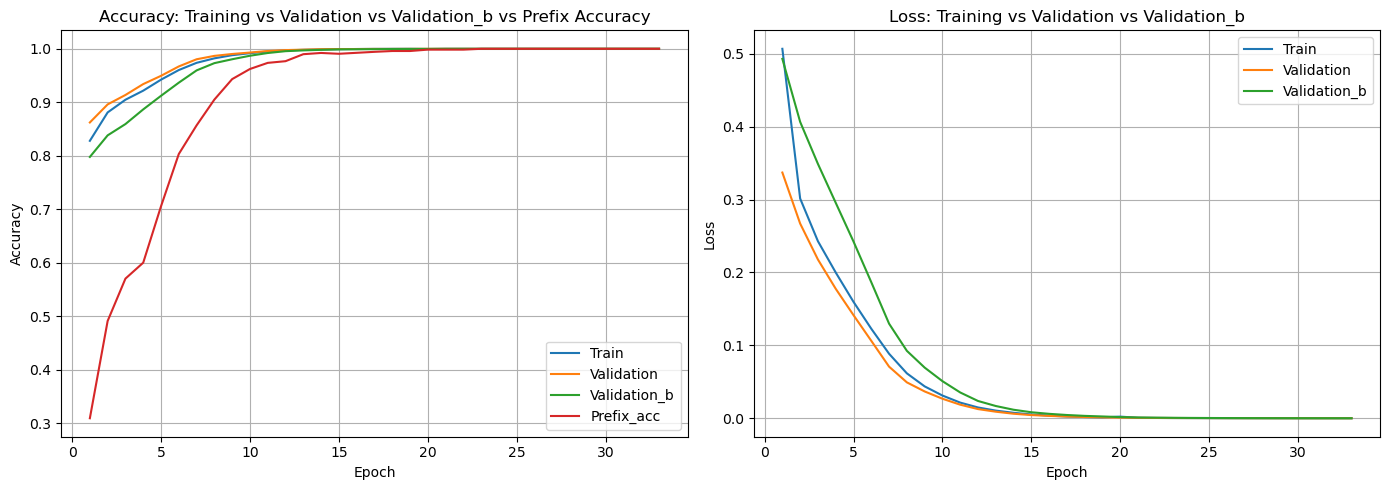

In [19]:
# Exstract history data
acc        = history.history['sparse_categorical_accuracy']
val_acc    = history.history['val_sparse_categorical_accuracy']
loss       = history.history['loss']
val_loss   = history.history['val_loss']
prefix_acc = prefix_cb.history
acc_val_b, loss_val_b = np.matrix(val_b.history)[:, 0], np.matrix(val_b.history)[:, 1]
epochs     = range(1, len(acc) + 1)

# Create images
fig1, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axs[0].plot(epochs, acc, label='Train')
axs[0].plot(epochs, val_acc, label='Validation')
axs[0].plot(epochs, acc_val_b, label='Validation_b')
axs[0].plot(epochs, prefix_acc, label='Prefix_acc')
axs[0].set_title('Accuracy: Training vs Validation vs Validation_b vs Prefix Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Loss
axs[1].plot(epochs, loss, label='Train')
axs[1].plot(epochs, val_loss, label='Validation')
axs[1].plot(epochs, loss_val_b, label='Validation_b')
axs[1].set_title('Loss: Training vs Validation vs Validation_b')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

As expected, the **Validation** accuracy is consistently higher than the **Train** accuracy—this is due to repeated samples in the validation set.
The **Prefix_acc** also reflects what we anticipated, given the metrics chosen for training.

More interestingly, after just one epoch, **Validation_b** (compose of unseen and more complex data) outperforms the training set as well. This behavior may be explained by the model being “overqualified” for the task—quickly learning the necessary rules.


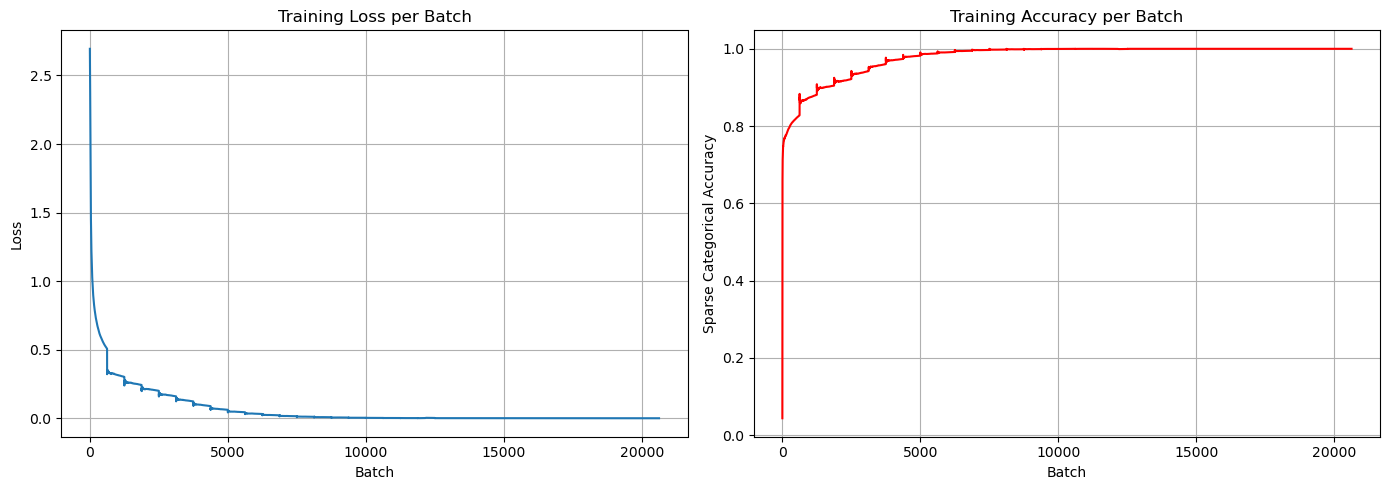

In [20]:
batches = range(1, len(batch_cb.batch_losses) + 1)
fig2, axs = plt.subplots(1, 2, figsize=(14, 5))

# Loss for batch
axs[0].plot(batches, batch_cb.batch_losses)
axs[0].set_title('Training Loss per Batch')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

# Accuracy for batch
axs[1].plot(batches, batch_cb.batch_acc, color='red')
axs[1].set_title('Training Accuracy per Batch')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Sparse Categorical Accuracy')
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Evaluation

In [21]:
mean_pref_acc, std_pref_acc = test(verbose_n=0)

round=0
------------------------------------------------
mean scores=1.0000 std=0.0000
round=1
------------------------------------------------
mean scores=1.0000 std=0.0000
round=2
------------------------------------------------
mean scores=1.0000 std=0.0000
round=3
------------------------------------------------
mean scores=1.0000 std=0.0000
round=4
------------------------------------------------
mean scores=1.0000 std=0.0000
round=5
------------------------------------------------
mean scores=1.0000 std=0.0000
round=6
------------------------------------------------
mean scores=1.0000 std=0.0000
round=7
------------------------------------------------
mean scores=1.0000 std=0.0000
round=8
------------------------------------------------
mean scores=1.0000 std=0.0000
round=9
------------------------------------------------
mean scores=1.0000 std=0.0000
FINAL SCORE = 1.0000 STD = 0.0000


In [22]:
%%capture test_out
for _ in range(5):
    print("Testing autoregressive decoding with 20 samples...")
    mean_pref_acc, std_pref_acc = test(verbose_n=0, verbose_round=False)

In [23]:
print(test_out.stdout)

Testing autoregressive decoding with 20 samples...
FINAL SCORE = 1.0000 STD = 0.0000
Testing autoregressive decoding with 20 samples...
FINAL SCORE = 1.0000 STD = 0.0000
Testing autoregressive decoding with 20 samples...
FINAL SCORE = 1.0000 STD = 0.0000
Testing autoregressive decoding with 20 samples...
FINAL SCORE = 1.0000 STD = 0.0000
Testing autoregressive decoding with 20 samples...
FINAL SCORE = 1.0000 STD = 0.0000



In [24]:
%%capture test_bonus_out
for depth in range(4,7):
    print()
    print(f"~~~~~~~~~~Testing with max_depth={depth}~~~~~~~~~~~~")
    mean_pref_acc, std_pref_acc = test(max_depth=depth, verbose_n=0, verbose_round=False)

In [25]:
print(test_bonus_out.stdout)


~~~~~~~~~~Testing with max_depth=4~~~~~~~~~~~~
FINAL SCORE = 0.3660 STD = 0.0308

~~~~~~~~~~Testing with max_depth=5~~~~~~~~~~~~
FINAL SCORE = 0.1031 STD = 0.0331

~~~~~~~~~~Testing with max_depth=6~~~~~~~~~~~~
FINAL SCORE = 0.0232 STD = 0.0220



## Conclusion

In [26]:
hparams = {'embed_dim':EMBED_DIM, 'enc_units':ENC_UNITS, 'dec_units':DEC_UNITS, 'batch_size':BATCH_SIZE}
outputs = {'training': report_cb.final_report, 'test': test_out.stdout, 'test_Depth': test_bonus_out.stdout}
figures = {'epoch': fig1, 'batch': fig2}
generate_report(hparams, outputs, figures, model = seq2seq, title = "model_v4.1")

In [27]:
# model
seq2seq.summary()

Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_model       │ [(None, None,     │      6,512 │ enc_inputs[0][0]  │
│ (Functional)        │ 32), (None, 32),  │            │                   │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_model       │ [(None, None,     │      7,519 │ dec_inputs[0][0], │
│ (Functional)        │ 15), (None, 32),  │            │ encoder_model[0]… │
│                     │ (None, 32)]       │            │ encoder_model[0]… │
│                     │                   │            │ encoder_model[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,095 (164.44 KB)

 Trainable params: 14,031 (54.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,064 (109.63 KB)

As shown in the previous outputs, the model (with **Total params: 1,802,351**) performs optimally for **DEPTH ≤ 3**  
It achieves also around **0.4** accuracy on samples with **DEPTH = 4**.

#### Possible Improvements to Implement

* Use two separate dictionaries
* Masked accuracy and use of “junk” tokens
* Dropout
* Multi-head (or single-head) attention
